In [59]:
import pandas as pd
import numpy as np 
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

# Basic feature engineering

Here, I extract some basic features for the data. I plan on using ensembe tree methods, which justifies some of my missing data imputation choices. 

## 0. Load data

This data was lighly processed in the Rmarkdown notebook `Basic-Features.Rmd`. 

In [2]:
train = pd.read_csv("../data/basic_features/train.csv")

In [3]:
test = pd.read_csv("../data/basic_features/test.csv")

In [8]:
train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,description_character_count_log,description_missing,price_mising,image_missing,param_1_missing,param_2_missing,param_3_missing,param_1_freq,param_2_freq,param_3_freq
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),...,4.077537,False,False,False,False,True,True,0.004292,0.441268,0.581002
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,...,3.737670,False,False,False,False,True,True,0.018966,0.441268,0.581002
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,...,4.605170,False,False,False,False,True,True,0.001430,0.441268,0.581002
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,...,3.135494,False,False,False,False,True,True,0.003416,0.441268,0.581002
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",...,3.218876,False,False,False,False,False,False,0.041317,0.013153,0.001273


In [9]:
test.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,description_character_count_log,description_missing,price_mising,image_missing,param_1_missing,param_2_missing,param_3_missing,param_1_freq,param_2_freq,param_3_freq
0,6544e41a8817,dbe73ad6e4b5,Волгоградская область,Волгоград,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,25,Отдам бесплатно,...,2.564949,False,True,False,False,False,False,0.075915,0.099026,0.004463
1,65b9484d670f,2e11806abe57,Свердловская область,Нижняя Тура,Хобби и отдых,Велосипеды,Дорожные,NaN,NaN,Продам велосипед,...,4.488636,False,False,True,False,True,True,0.001253,0.441268,0.581002
2,8bab230b2ecd,0b850bbebb10,Новосибирская область,Бердск,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,BBK,...,4.890349,False,False,False,False,True,True,0.005112,0.441268,0.581002
3,8e348601fefc,5f1d5c3ce0da,Саратовская область,Саратов,Для дома и дачи,Бытовая техника,Для кухни,Вытяжки,NaN,Вытяжка Jetair 60,...,4.543295,False,False,True,False,False,True,0.010668,0.000281,0.581002
4,8bd2fe400b89,23e2d97bfc7f,Оренбургская область,Бузулук,Личные вещи,Товары для детей и игрушки,Детские коляски,NaN,NaN,Коляска зима-лето,...,4.110874,False,False,False,False,True,True,0.017852,0.441268,0.581002


## 1. Tf-Idf features

Now, I'll experiment with the presence/lack of presence of words that appear in different frequencies in the training data in examples with different ranges of `deal_probability`.

First, categorize the probabilities in broad bins:

In [4]:
def get_prob_group(prob):
    if prob == 0:
        return "zero"
    elif prob < .27:
        return "low"
    elif prob < .7:
        return "mid"
    elif prob < 1:
        return "high"
    else:
        return "certain"

In [5]:
# bin the probabilities
train['prob_group'] = train.deal_probability.map(lambda x: get_prob_group(x))

Now, group the words in the titles, grouped by the probability group and the parent category. First, though, remove words with numeric values, as these usually are of very low frequency. (which will lead to high "idf", but are unlikely to move onto the test set.)

In [6]:
# first, remove words with numbers
tmp = train
tmp.title = tmp.title.apply(lambda x: re.sub(r'\w*\d\w*', '', x).strip())

In [80]:
tmp.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,description_missing,price_mising,image_missing,param_1_missing,param_2_missing,param_3_missing,param_1_freq,param_2_freq,param_3_freq,prob_group
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),...,False,False,False,False,True,True,0.004292,0.441268,0.581002,low
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,...,False,False,False,False,True,True,0.018966,0.441268,0.581002,zero
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,...,False,False,False,False,True,True,0.001430,0.441268,0.581002,mid
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,...,False,False,False,False,True,True,0.003416,0.441268,0.581002,high
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ ,",...,False,False,False,False,False,False,0.041317,0.013153,0.001273,low


In [81]:
word_groups = tmp.groupby(["parent_category_name", "prob_group"])['title'].apply(
    lambda x: " ".join(list(x))).reset_index()  

In [82]:
word_groups

,parent_category_name,prob_group,title
0,Бытовая электроника,high,Телевизор цветной Магнитола Настольный компьют...
1,Бытовая электроника,low,ЖК- монитор Xbox Roverpad air . Zte blade Теле...
2,Бытовая электроника,mid,Philips bluray Radeon Симочки для регистрации ...
3,Бытовая электроника,zero,Монитор acer . Кулер для компьютера cooler mas...
4,Для бизнеса,high,Компрессор воздушный fubag Сплит система Ванна...
5,Для бизнеса,low,Аппарат для попкорна PM- Мясорубка Установка д...
6,Для бизнеса,mid,"Модуль тип ""Орск"" * Морозильник Шиномонтаж Тор..."
7,Для бизнеса,zero,Парикмахерское кресло Статус на гидравлике Вес...
8,Для дома и дачи,high,"Матрас Стиральная машина LG, кг., гарантия Про..."
9,Для дома и дачи,low,Яйцо куриное Маранта Кухонный шкаф Спальный га...


Now, I want to build a tf-idf vectorizer. First, loading a list of russian stopwords

In [7]:
stopwords = pd.read_csv("../data/stopwords/russian_stopwords.txt", header=None)[0].values.tolist()

In [207]:
title_vect = TfidfVectorizer(stop_words = stopwords, ngram_range=(1,2))

And now fitting the transformer to the grouped data

In [208]:
# fit a tf-idf vectorizer onto the titles
title_tf_idf = title_vect.fit_transform(word_groups.title.values)

In [212]:
reverse_vocab = {v:k for k,v in title_vect.vocabulary_.items()}

In [8]:
def build_top_set(tfidf_matrix, reverse_vocab, top = 3):
    top_words = set()
    for doc in range(tfidf_matrix.shape[0]):
        top_indecies = np.asarray(tfidf_matrix[doc].todense()).argsort().reshape((-1,))[-top:]
        for ind in top_indecies:
            top_words.add(reverse_vocab[ind])
    return top_words

In [213]:
title_top3 = build_top_set(title_tf_idf, reverse_vocab, top = 3)

In [214]:
title_top3

{'asus',
 'iphone',
 'lada',
 'samsung',
 'samsung galaxy',
 'toyota',
 'аквариум',
 'ваз',
 'ваз samara',
 'велосипед',
 'витрина',
 'грузоперевозки',
 'детский велосипед',
 'диван',
 'добрые',
 'добрые руки',
 'квартира м²',
 'коляска',
 'коньки',
 'кровать',
 'кроссовки',
 'куртка',
 'м²',
 'м² эт',
 'монеты',
 'оборудование',
 'отдам',
 'платье',
 'продам',
 'работы',
 'ремонт',
 'руки',
 'ссср',
 'станок',
 'стиральная',
 'телевизор',
 'туфли',
 'услуги',
 'холодильная',
 'холодильник',
 'щенки'}

Some of these tokens are interesting, like "samsung galaxy" and "квартира м²" (apartment meters squared"), but they don't seem super particular to a parent category. Perhaps it would be better to simply group by the deal probability. 

In [9]:
# gather the words simply based on the probability group they're in. 
prob_group_words = tmp.groupby('prob_group')['title'].apply(
    lambda x: " ".join(list(x))).reset_index()  

In [185]:
prob_group_vect = TfidfVectorizer(stop_words=stopwords)

In [186]:
prob_group_tfidf = prob_group_vect.fit_transform(prob_group_words.title.values)

In [187]:
reverse_vocab_prob_group = {k:v for v, k in prob_group_vect.vocabulary_.items()}

In [10]:
prob_group_words

,prob_group,title
0,certain,"Монтаж дверей, проемов, откосов, арок Наращива..."
1,high,Автокресло Авто люлька Бойфренды colins Бычки ...
2,low,"Кокоби(кокон для сна) ВАЗ , Атласы и Контурныя..."
3,mid,"Philips bluray -к квартира, м², / эт. Chevrol..."
4,zero,Стойка для Одежды Водонагреватель литров нерж...


In [267]:
top_words_probgroup = build_top_set(prob_group_tfidf, reverse_vocab_prob_group, top = 10)

In [268]:
top_words_probgroup

{'iphone',
 'samsung',
 'авто',
 'аренда',
 'аренду',
 'ваз',
 'велосипед',
 'грузоперевозки',
 'грузчики',
 'ижс',
 'квартира',
 'коляска',
 'комбинезон',
 'костюм',
 'куртка',
 'м²',
 'наращивание',
 'новые',
 'платье',
 'продам',
 'работы',
 'ремонт',
 'репетитор',
 'сниму',
 'сот',
 'туфли',
 'услуги',
 'участке',
 'участок',
 'эт'}

Again, some of these are interesting. BUt per

In [11]:
prob_group_bigram_vect = TfidfVectorizer(stop_words=stopwords, ngram_range=(1,2))

In [12]:
prob_group_bigram_tfidf = prob_group_bigram_vect.fit_transform(prob_group_words.title.values)

In [13]:
reverse_vocab_prob_group_bigram = {k:v for v, k in prob_group_bigram_vect.vocabulary_.items()}

In [14]:
top_bigrams_probgroup = build_top_set(prob_group_bigram_tfidf, reverse_vocab_prob_group_bigram, top = 15)

In [15]:
top_bigrams_probgroup

{'iphone',
 'samsung',
 'авто',
 'аренда',
 'аренду',
 'ботинки',
 'ваз',
 'велосипед',
 'газель',
 'грузоперевозки',
 'грузчики',
 'детский',
 'диван',
 'ижс',
 'квартир',
 'квартира',
 'квартира м²',
 'коляска',
 'комбинезон',
 'костюм',
 'куртка',
 'м²',
 'м² участке',
 'м² эт',
 'мастер',
 'наращивание',
 'новые',
 'пальто',
 'платье',
 'продам',
 'работы',
 'ремонт',
 'репетитор',
 'сапоги',
 'сниму',
 'сот',
 'сот ижс',
 'строительство',
 'туфли',
 'услуги',
 'установка',
 'участке',
 'участке сот',
 'участок',
 'участок сот',
 'эт',
 'эт квартира'}

In [16]:
# annoying leftover stopwords
top_bigrams_probgroup.remove("эт")
top_bigrams_probgroup.remove("сот")

In [17]:
def add_title_token_cols(df, tokens):
    for token in tokens:
        colname = "contains_" + token.replace(" ", "_")
        df[colname] = df.title.apply(lambda x: token in x.lower())
    return df

In [18]:
train = add_title_token_cols(train, top_bigrams_probgroup)

In [19]:
test = add_title_token_cols(test, top_bigrams_probgroup)

In [20]:
train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,contains_ремонт,contains_комбинезон,contains_наращивание,contains_коляска,contains_диван,contains_samsung,contains_продам,contains_костюм,contains_авто,contains_iphone
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),...,False,False,False,False,False,False,False,False,False,False
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,...,False,False,False,False,False,False,False,False,False,False
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,...,False,False,False,False,False,False,False,False,False,False
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,...,False,False,False,False,False,False,False,False,True,False
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ ,",...,False,False,False,False,False,False,False,False,False,False


---

## 2. One-hot encode columns

First, adding one hot encodings to the parent category

In [20]:
category_enc = LabelEncoder()

In [21]:
category_enc.fit(np.append(train['parent_category_name'],test['parent_category_name']).reshape(-1,1))

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LabelEncoder()

In [22]:
train['category_int_encoding'] = category_enc.transform(train.parent_category_name)

In [23]:
train = train.join(pd.get_dummies(train.category_int_encoding, prefix = "parent_category_"))

In [24]:
test['category_int_encoding'] = category_enc.transform(test.parent_category_name)

In [25]:
test = test.join(pd.get_dummies(test.category_int_encoding, prefix = "parent_category_"))

In [329]:
train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,category_int_encoding,parent_category__0,parent_category__1,parent_category__2,parent_category__3,parent_category__4,parent_category__5,parent_category__6,parent_category__7,parent_category__8
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),...,4,0,0,0,0,1,0,0,0,0
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,...,2,0,0,1,0,0,0,0,0,0
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,...,0,1,0,0,0,0,0,0,0,0
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,...,4,0,0,0,0,1,0,0,0,0
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",...,6,0,0,0,0,0,0,1,0,0


Now, to the user type

In [26]:
user_type_enc = LabelEncoder()

In [27]:
user_type_enc.fit(np.append(test.user_type, train.user_type))

LabelEncoder()

In [28]:
train['user_type_enc'] = user_type_enc.transform(train.user_type)

In [29]:
train = train.join(pd.get_dummies(train.user_type_enc, prefix = "user_type_"))

In [30]:
test['user_type_enc'] = user_type_enc.transform(test.user_type)

In [31]:
test = test.join(pd.get_dummies(test.user_type_enc, prefix = "user_type_"))

And now, region:

In [32]:
region_enc = LabelEncoder()

In [33]:
region_enc.fit(np.append(train.region, test.region))

LabelEncoder()

In [34]:
train.region_int_enc = region_enc.transform(train.region)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [35]:
train = train.join(pd.get_dummies(train.region_int_enc, prefix = "region_"))

In [36]:
test.region_int_enc = region_enc.transform(test.region)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [37]:
test = test.join(pd.get_dummies(test.region_int_enc, prefix = "region_"))

## 3. Fill missing columns

Now we'll have to fill in the missing values in the numeric columns we'd like to use. Since I plan on using ensemble trees methods, I'll just put in characters outside the ranges of these columns; tree algorithms can distinguish between legitimate values and these imputed values with one additional split per feature. 

In [348]:
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(train.isnull().sum(axis=0))

item_id                                  0
user_id                                  0
region                                   0
city                                     0
parent_category_name                     0
category_name                            0
param_1                              61576
param_2                             654542
param_3                             862565
title                                    0
description                         116276
price                                85362
item_seq_number                          0
activation_date                          0
user_type                                0
image                               112588
image_top_1                         112588
deal_probability                         0
days_since_previous_appearence      771769
days_since_previous_appearence2    1011788
avg_appearences_per_day_prev       1347320
daily_ad_number                          0
daily_ad_number_category                 0
city_freque

First, starting with price

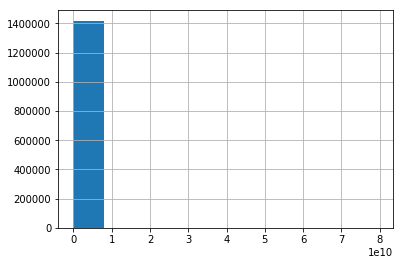

In [351]:
train.price.hist()

If I impute the price with something negative, it will be out of the range. 

In [38]:
train.price = train.price.fillna(-999)

In [39]:
test.price = test.price.fillna(-999)

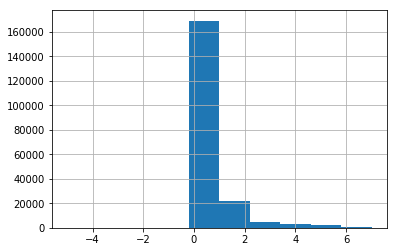

In [364]:
test.days_since_previous_appearence.hist()

Some noisy values (bugs) lead to 13 negative values for this feature. If I fill in the missing values with -100, though, it will be out of range. 

In [40]:
train.days_since_previous_appearence = train.days_since_previous_appearence.fillna(-100)

In [41]:
test.days_since_previous_appearence = test.days_since_previous_appearence.fillna(-100)

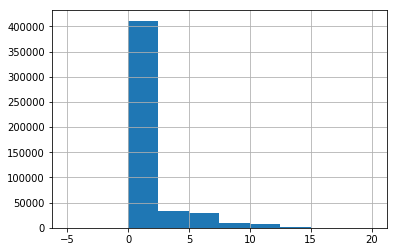

In [42]:
train.days_since_previous_appearence2.hist()

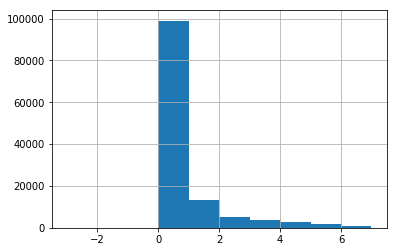

In [367]:
test.days_since_previous_appearence2.hist()

Same deal with `days_since_previous_appearence2.hist()`

In [43]:
train.days_since_previous_appearence2 = train.days_since_previous_appearence2.fillna(-100)

In [44]:
test.days_since_previous_appearence2 = test.days_since_previous_appearence2.fillna(-100)

Now, `avg_appearences_per_day_prev`:

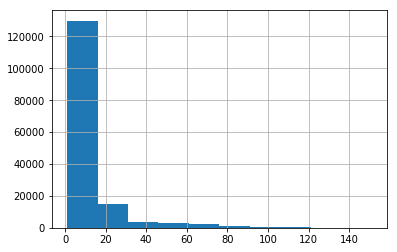

In [373]:
train.avg_appearences_per_day_prev.hist()

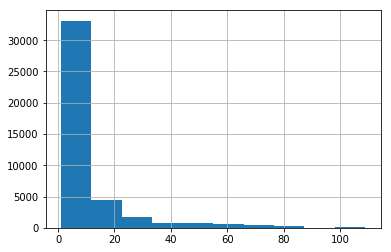

In [375]:
test.avg_appearences_per_day_prev.hist()

Any negative value will do. 

In [45]:
train.avg_appearences_per_day_prev = train.avg_appearences_per_day_prev.fillna(-10)

In [46]:
test.avg_appearences_per_day_prev = test.avg_appearences_per_day_prev.fillna(-10)

`image_top_1`:

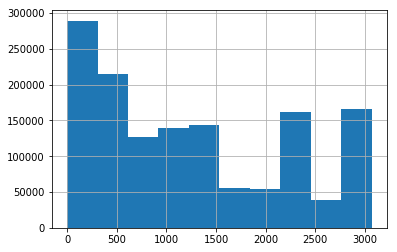

In [378]:
train.image_top_1.hist()

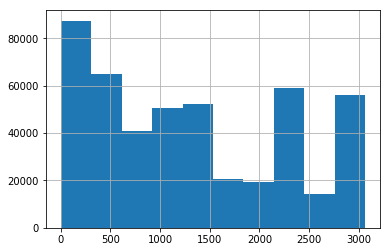

In [379]:
test.image_top_1.hist()

Any negative value will do.

In [47]:
train.image_top_1 = train.image_top_1.fillna(-999)

In [48]:
test.image_top_1 = test.image_top_1.fillna(-999)

`description_word_count_log` and `description_character_count_log`

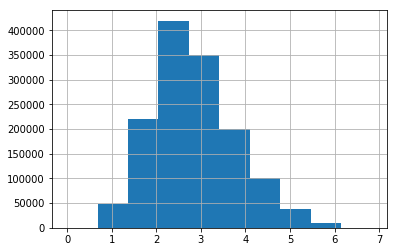

In [386]:
train.description_word_count_log.hist()

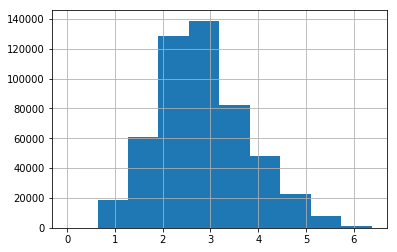

In [387]:
test.description_word_count_log.hist()

In [49]:
train.description_word_count_log = train.description_word_count_log.fillna(-999)

In [50]:
test.description_word_count_log = test.description_word_count_log.fillna(-999)

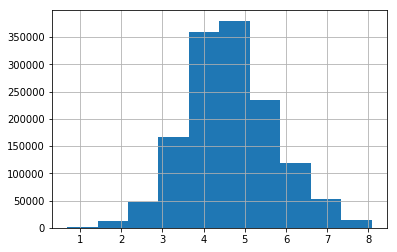

In [390]:
train.description_character_count_log.hist()

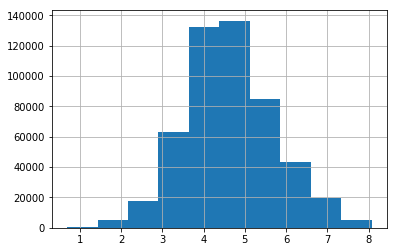

In [391]:
test.description_character_count_log.hist()

In [51]:
train.description_character_count_log = train.description_character_count_log.fillna(-999)

In [52]:
test.description_character_count_log = test.description_character_count_log.fillna(-999)

## 4. Save data

Now that we have our first set of basic features, I'll save then as numpy binary arrays, so that I can train them elsewhere. 

In [398]:
mkdir ../data/first_features

In [53]:
traincols = list(train.columns)

In [54]:
for col in ["item_id", "user_id", "region", 
           "city", "parent_category_name", "category_name", 
           "param_1", "param_2", "param_3",
           "title", "description", "activation_date", "image", 
           "deal_probability", "prob_group", "category_int_encoding",
           "user_type_enc", "user_type"]:
    traincols.remove(col)

In [71]:
np.save("../data/first_features/X.npy", train[traincols].values)

In [72]:
np.save("../data/first_features/X_test.npy", test[traincols].values)

In [ ]:
np.save("../data/first_features/y.npy", train['deal_probability'])

In [61]:
with open("../data/first_features/colnames.pkl", "wb") as handle:
    pickle.dump(traincols,handle)